# CSE 555 - Introduction to pattern recognition
## Problem Set 1: Bayesian Decision Theory

Dataloader to read the MNIST dataset. The dataset is read and is flattened. Hence each 28x28 image is now a vector of length 784.

In [304]:
import numpy as np


def load_mnist(kind='train'):
    import os
    import gzip

    """Load MNIST data from `path`"""
    labels_path = ('%s-labels-idx1-ubyte.gz' % kind)
    images_path = ('%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


x_train, y_train = load_mnist(kind='train')
x_test, y_test = load_mnist(kind='t10k')

Segregating dataset into a dictionary consisting of 0-9 digits as key and the list of image pixels as values

In [306]:
train_data_dict = dict()
for i in range(len(y_train)):
    if(y_train[i] in train_data_dict):
        train_data_dict[y_train[i]].append([x_train[i]])
    else:
        train_data_dict[y_train[i]] = list()
        train_data_dict[y_train[i]].append([x_train[i]])

### TASK 1:
Calculating the mean and standard deviation for each of the digit individially. Saving and visualizing the "mean digits" and "standard deviation digits" in current directory and by plotting them inline.

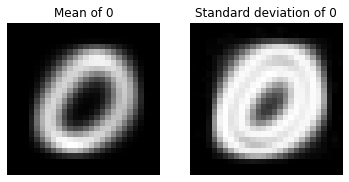

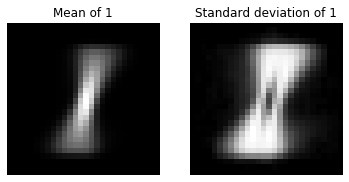

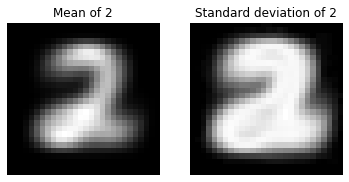

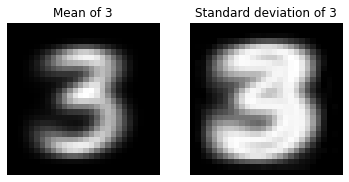

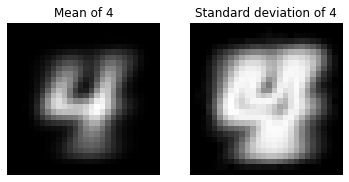

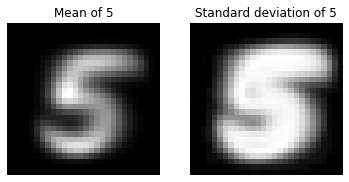

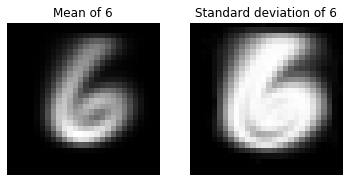

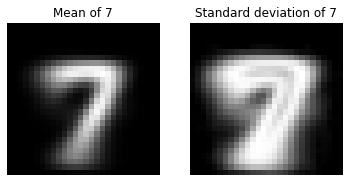

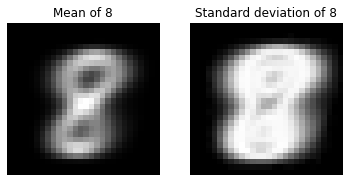

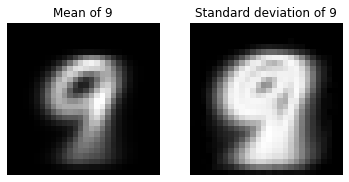

In [307]:
import cv2
import os
import matplotlib.pyplot as plt

if not os.path.exists('./mean_digits'):
    os.makedirs('./mean_digits')
if not os.path.exists('./standard_deviation_digits'):
    os.makedirs('./standard_deviation_digits')
if not os.path.exists('./output_subplots'):
    os.makedirs('./output_subplots')
    
mean_list = list()
sd_list = list()

for i in range(10):
    fig, a =  plt.subplots(1, 2)
    mean_list.append(np.mean(np.asarray(train_data_dict[i]), axis=(0)).transpose())
    cv2.imwrite('./mean_digits/mean_'+str(i)+'.png', np.asarray(mean_list[i]).reshape(28, 28))
    sd_list.append(np.std(np.asarray(train_data_dict[i]), axis=(0)).transpose())
    cv2.imwrite('./standard_deviation_digits/sd_'+str(i)+'.png', np.asarray(sd_list[i]).reshape(28, 28))
    a[0].imshow(np.asarray(mean_list[i]).reshape(28, 28), cmap = 'gray')
    a[0].set_title('Mean of '+str(i))
    a[0].axis('off')
    a[1].imshow(np.asarray(sd_list[i]).reshape(28, 28), cmap = 'gray')
    a[1].set_title('Standard deviation of '+str(i))
    a[1].axis('off')
    plt.savefig('./output_subplots/mean_sd_'+str(i)+'.png', dpi=300)
    plt.show()

Setting up the dataset as pandas data series for the processing of task 2.

In [308]:
import pandas as pd

train_data_frame = pd.DataFrame(x_train,y_train)
train_data_mean = list()
train_data_sd = list()
for i in range(10):
    mean = train_data_frame.loc[i].sum()/len(train_data_frame.loc[i])
    sd = np.sqrt(((train_data_frame.loc[i]-mean)**2).sum()/len(train_data_frame.loc[i]))
    train_data_mean.append(mean)
    train_data_sd.append(sd)

### Task 2:
Calculating the covariance and the inverse matrix as it is required in the implementation of Bayesian decision rule. 

In [310]:
covariance = list()
inverse = list()

for i in range(len(train_data_sd)):
    for j in range(len(train_data_sd[0])):
        train_data_sd[i][j] += 0.001

for i in range(len(train_data_sd)):
    a = np.diag(train_data_sd[i]**2)
    covariance.append(a)
    b = np.linalg.inv(covariance[i])
    inverse.append(b)

Implementation of Bayesian decision rule.

* Guassian Distribution - The LDA function is derived by the above equation.
 
\begin{align}
p(x)=\frac{1}{(2π)^{d/2}|\sum|^{1/2}}exp(−\frac{1}{2}(x−\mu)^{′}\sum^{−1}(x−\mu))
\end{align}

 * Then we take Log Likelyhood of the above equation to get the discriminant function.
 
 \begin{align}
\boldsymbol{g_{i}(x) = \log p(x|\omega_i) + \log P(\omega_i)}
\end{align}
\begin{align}
\newline = -\frac{1}{2}(x - \mu_{i})^{-1} \sum^{-1}(x - \mu_{i}) - \frac{d}{2} \log (2 \pi) -\frac{1}{2} \log |\sum_i| + \log P(\omega_i)
\end{align}

 * Now we take the case 3 of the LDA (arbitrary covariances)
   Case 3 is defined by:
   
\begin{align}
\boldsymbol{g_i = x^{t} W_i x + N_{i}^{t} x + B_{i0}}
\end{align}
\begin{align}
\newline
where, W_i = - \frac{1}{2} \sum_{i}^{-1} , N_{i} = \sum_{i}^{-1} \mu_{i} and B_{i0} = - \frac{1}{2} \mu_{i}^{t} \sum_{i}^{-1} \mu_{i} + ln P(w_i) - \frac{1}{2} ln |\sum_{i}| 
\end{align}

In [318]:
W = list()
N = list()
B = list()
g = list()
y_pred = list()

inverse = np.asarray(inverse)
train_data_mean = np.asarray(train_data_mean)
for i in range(len(train_data_sd)):
    W.append(inverse[i]*(-0.5))
    N.append(np.matmul(inverse[i], train_data_mean[i]))
    b1 = np.matmul(np.matmul(train_data_mean[i].T, inverse[i]), train_data_mean[i])
    B.append((-0.5)*b1)
    
N = np.asarray(N)
for i in range(len(x_test)):
    g = list()
    for j in range(len(train_data_sd)):
        g.append(B[j] + np.matmul(N[j].T, x_test[i]) + np.matmul(np.matmul(x_test[i].T, W[j]), x_test[i]))
    
    y_pred.append(np.argmax(g))

Calculation of accuracy using 0-1 loss function

Accuracy:  81.73
Confusion matrix:


AttributeError: module 'seaborn' has no attribute 'set_xlabel'

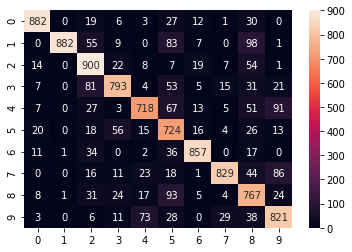

In [328]:
import sklearn.metrics
import seaborn as sn

print("Accuracy: ", (100-sklearn.metrics.zero_one_loss(y_test, y_pred)*100))
print("Confusion matrix:")
df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, y_pred), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
sn.heatmap(df_cm, annot=True, fmt='d')
sn.set_xlabel('y_pred')
sn.set_ylabel('y_pred')

### Why it doesn't perform as good as many other methods on LeCun's web page?
1) One main reason is that the Discriminant Analysis makes the label prediction on the basis of similarity of the mean and standard deviation of images and not individual features themselves.
2) Another reason is the assumption that the feature vectors in each category have Gaussian distribution